In [1]:
import os

dirs = [
    "project/data/raw/inside_airbnb",
    "project/data/raw/kaggle",
    "project/data/processed",
    "project/notebooks",
    "project/src",
    "project/docs"
]

for d in dirs:
    os.makedirs(d, exist_ok=True)

with open("project/README.md", "w") as f:
    f.write("# Airbnb London Project\n")


In [9]:
import pandas as pd

# 读取数据
df = pd.read_csv("project/data/raw/inside_airbnb/listings.csv.gz")

# 查看前几行
df.head()

# 查看字段信息
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461 entries, 0 to 460
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            461 non-null    int64  
 1   listing_url                                   461 non-null    object 
 2   scrape_id                                     461 non-null    int64  
 3   last_scraped                                  461 non-null    object 
 4   source                                        461 non-null    object 
 5   name                                          461 non-null    object 
 6   description                                   452 non-null    object 
 7   neighborhood_overview                         180 non-null    object 
 8   picture_url                                   461 non-null    object 
 9   host_id                                       461 non-null    int

In [14]:
print(df.columns.tolist())


['listing_id', 'host_id', 'room_type', 'latitude', 'longitude', 'price', 'license', 'neighbourhood']


In [24]:
cols = ["listing_id","host_id","room_type","latitude","longitude","price","license","neighbourhood"]
df_core = df[cols].copy()
df_core.head()


,listing_id,host_id,room_type,latitude,longitude,price,license,neighbourhood
0,2992450,4621559,Entire home/apt,42.65789,-73.75370,$93.00,NaN,NaN
1,3820211,19648678,Entire home/apt,42.65222,-73.76724,$91.00,NaN,Neighborhood highlights
2,5651579,29288920,Entire home/apt,42.64615,-73.75966,$64.00,NaN,Neighborhood highlights
3,6623339,19648678,Entire home/apt,42.65222,-73.76724,$95.00,NaN,Neighborhood highlights
4,9005989,17766924,Entire home/apt,42.65559,-73.76506,$89.00,NaN,Neighborhood highlights


In [30]:
df_core["price"] = (
    df_core["price"].astype(str)              # 先转成字符串
    .str.replace("$", "", regex=False)        # 去掉美元符号
    .str.replace(",", "", regex=False)        # 去掉逗号
    .astype(float)                            # 转回浮点数
)


In [31]:
print(df_core["price"].dtype)
print(df_core["price"].head())


float64
0    93.0
1    91.0
2    64.0
3    95.0
4    89.0
Name: price, dtype: float64


In [32]:
# 价格分布
print(df_core["price"].describe())


count     425.000000
mean      119.880000
std       119.955032
min        24.000000
25%        68.000000
50%        94.000000
75%       126.000000
max      1314.000000
Name: price, dtype: float64


In [33]:
# 标记整套的房源
df_core["is_entire_home"] = df_core["room_type"] == "Entire home/apt"


In [34]:
# 识别职业房东
host_counts = df_core.groupby("host_id")["listing_id"].nunique()
df_core = df_core.merge(host_counts.rename("n_listings"), on="host_id", how="left")
df_core["is_multi_host"] = df_core["n_listings"] >= 2


In [35]:
# 登记号合规性
df_core["has_license"] = df_core["license"].notna() & (df_core["license"].astype(str).str.strip() != "")


In [36]:
# 输出核心指标
print({
    "总房源数": len(df_core),
    "整套房源比例": round(df_core["is_entire_home"].mean(), 3),
    "职业房东比例": round(df_core["is_multi_host"].mean(), 3),
    "登记合规率": round(df_core["has_license"].mean(), 3)
})


{'总房源数': 461, '整套房源比例': np.float64(0.753), '职业房东比例': np.float64(0.748), '登记合规率': np.float64(0.0)}


/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25151 (\N{CJK UNIFIED IDEOGRAPH-623F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28304 (\N{CJK UNIFIED IDEOGRAPH-6E90}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  fig.canvas

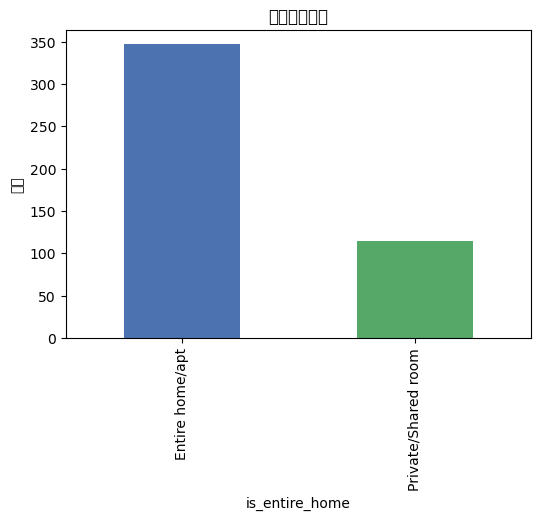

In [37]:
import matplotlib.pyplot as plt

# 统计数量
room_counts = df_core["is_entire_home"].value_counts().rename({True: "Entire home/apt", False: "Private/Shared room"})

# 绘制柱状图
fig, ax = plt.subplots(figsize=(6,4))
room_counts.plot(kind="bar", color=["#4C72B0", "#55A868"], ax=ax)
ax.set_title("房源类型分布")
ax.set_ylabel("数量")
plt.show()


/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32844 (\N{CJK UNIFIED IDEOGRAPH-804C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 19994 (\N{CJK UNIFIED IDEOGRAPH-4E1A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25151 (\N{CJK UNIFIED IDEOGRAPH-623F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 19996 (\N{CJK UNIFIED IDEOGRAPH-4E1C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas

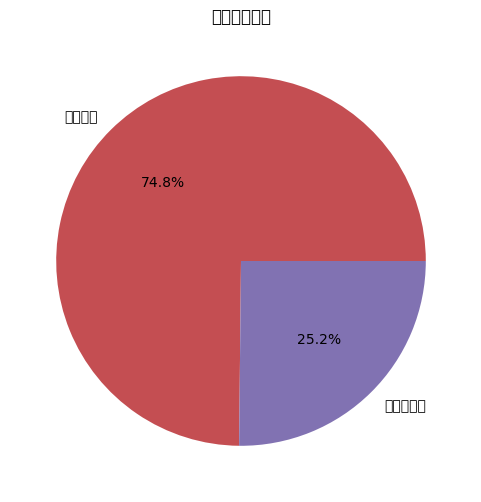

In [38]:
# 统计比例
host_counts = df_core["is_multi_host"].value_counts().rename({True: "职业房东", False: "非职业房东"})

# 绘制饼图
fig, ax = plt.subplots(figsize=(6,6))
host_counts.plot(kind="pie", autopct="%1.1f%%", colors=["#C44E52", "#8172B2"], ax=ax)
ax.set_ylabel("")
ax.set_title("职业房东比例")
plt.show()


/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32428 (\N{CJK UNIFIED IDEOGRAPH-7EAC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25151 (\N{CJK UNIFIED IDEOGRAPH-623F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28304 (\N{CJK UNIFIED IDEOGRAPH-6E90}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31354 (\N{CJK UNIFIED IDEOGRAPH-7A7A}) missing from font(s) DejaVu Sans.
  fig.canvas

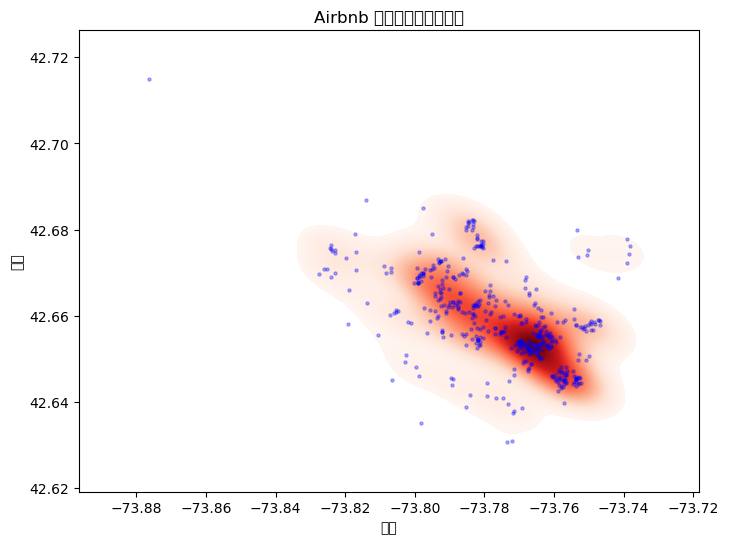

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# 只保留坐标非空的房源
df_map = df_core[["latitude", "longitude"]].dropna()

plt.figure(figsize=(8,6))

# 使用 seaborn 的 kdeplot 绘制二维核密度估计热力图
sns.kdeplot(
    x=df_map["longitude"],
    y=df_map["latitude"],
    cmap="Reds", fill=True, thresh=0.05, levels=100
)

# 添加散点作为参考（可选）
plt.scatter(df_map["longitude"], df_map["latitude"], s=5, alpha=0.3, color="blue")

# 设置标题和坐标轴标签
plt.title("Airbnb 房源空间分布热力图")
plt.xlabel("经度")
plt.ylabel("纬度")

plt.show()
